In [2]:
import numpy as np
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from requests import get
import unicodedata
#from bs4 import BeautifulSoup
#import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

# Reading in the data

In [3]:
df = pd.read_csv('movie_metadata.csv')

In [4]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000.0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0.0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000.0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000.0
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0.0


In [5]:
df.shape

(5043, 28)

In [6]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4927.000000,4959.000000,4872.000000,4953.000000,4968.000000,4.104000e+03,4.974000e+03,4974.000000,4961.000000,4956.000000,4.494000e+03,4869.000000,4963.000000,4974.000000,4654.000000,4974.000000
mean,140.572965,107.193991,691.233990,647.790430,6573.525765,4.862765e+07,8.382561e+04,9729.287495,1.372707,273.584746,3.998652e+07,2002.487985,1660.086641,6.439767,2.223350,7572.120828
std,121.858265,24.977939,2822.022077,1672.724849,15077.147622,6.853339e+07,1.386775e+05,18228.145064,2.017257,378.750005,2.073754e+08,12.433410,4055.957071,1.124002,1.393249,19422.681479
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,135.000000,617.000000,5.480826e+06,8.688250e+03,1430.250000,0.000000,65.000000,6.000000e+06,1999.000000,284.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,372.000000,989.000000,2.559138e+07,3.450400e+04,3097.500000,1.000000,157.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,165.500000
75%,195.000000,118.000000,197.000000,636.000000,11000.000000,6.241428e+07,9.646275e+04,13808.750000,2.000000,327.000000,4.500000e+07,2011.000000,919.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


# Filling NAN's with median.

In [7]:
def fill_nan(col):
    df[col] = df[col].fillna(df[col].median())

cols = list(df.columns)
fill_nan(cols)

# Cleaning

In [8]:
def clean_backward_title(col):
    string = col.rstrip()[:-2]
    return unicodedata.normalize('NFD', unicode(string, 'utf-8')).encode('ascii', 'ignore')

In [9]:
df['movie_title'] = df['movie_title'].astype(str)

In [10]:
df['movie_title'] = df['movie_title'].apply(clean_backward_title)

# IMDB Revenue scraping script. Redundant right now.. but can be useful in other projects

In [11]:
# def revenue_parse(url, revenue_per_movie):
#     url = url + 'business'
#     response = get(url)
#     html_soup = BeautifulSoup(response.text, 'html.parser')
#     movie_containers = html_soup.find('div', {"id": "tn15content"})
#     text_spend = movie_containers.text.split('\n')
#     if 'Gross' in text_spend:
#         gross_index = text_spend.index('Gross')
#         rev = [int(i[1:].replace(',', '')) if i[1:].replace(',', '').isdigit() else -1 for i in re.findall(r'[$]\S*', text_spend[gross_index+1])]
#         if len(rev) == 0:
#             revenue_per_movie.append(-1)
#         else:
#             revenue_per_movie.append(max(rev))
#     else:
#         revenue_per_movie.append(-1)


# revenue_per_movie = []

# for i in df['url']:
#     revenue_parse(i, revenue_per_movie)

# Describing the data to find the Missing values

In [12]:
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,5043.000000,5043.000000,5043.000000,5043.000000,5043.00000,5.043000e+03,5.043000e+03,5043.000000,5043.000000,5043.000000,5.043000e+03,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000
mean,139.869720,107.124132,669.456871,642.868531,6490.47214,4.433833e+07,8.315077e+04,9638.549177,1.366647,271.573468,3.781071e+07,2002.574658,1643.190561,6.441959,2.233119,7470.780984
std,120.535511,24.774814,2776.189759,1658.130651,14979.85268,6.247029e+07,1.378445e+05,18119.377709,2.001342,375.774914,1.958590e+08,12.225589,4025.851655,1.116440,1.338851,19308.507567
min,1.000000,7.000000,0.000000,0.000000,0.00000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,51.000000,93.000000,8.000000,139.500000,625.00000,9.116578e+06,8.972500e+03,1442.000000,0.000000,67.000000,7.500000e+06,1999.000000,290.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,372.000000,989.00000,2.559138e+07,3.450400e+04,3097.500000,1.000000,157.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,165.500000
75%,192.000000,117.000000,188.000000,633.000000,11000.00000,5.089081e+07,9.444550e+04,13629.500000,2.000000,322.000000,4.000000e+07,2010.000000,912.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.00000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


# Normalizing or Standardizing the data.. change the commenting as per your needs

In [13]:
col = list(df.describe().columns)

In [14]:
sc = StandardScaler()
# sc = MinMaxScaler()
temp = sc.fit_transform(df[col])
df[col] = temp
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,4.838309,2.861087,-0.241166,0.127947,Joel David Moore,-0.366560,11.465267,Action|Adventure|Fantasy|Sci-Fi,...,7.405237,English,USA,PG-13,1.017104,0.525617,-0.175680,1.306103,-0.338472,1.322306
1,Color,Gore Verbinski,1.345216,2.497779,-0.038350,0.215403,Orlando Bloom,2.237195,4.243491,Action|Adventure|Fantasy,...,2.572078,English,USA,PG-13,1.338796,0.362010,0.833896,0.589468,0.087308,-0.386955
2,Color,Sam Mendes,3.834356,1.650060,-0.241166,-0.290638,Rory Kinnear,0.301069,2.493206,Action|Adventure|Thriller,...,1.922689,English,UK,PG-13,1.057954,1.016440,-0.310571,0.320731,0.087308,4.015686
3,Color,Christopher Nolan,5.585051,2.295941,7.684150,13.484672,Christian Bale,1.369277,6.464391,Action|Thriller,...,6.465752,English,USA,PG-13,1.083485,0.771028,5.305443,1.843579,0.087308,8.107553
4,NaN,Doug Walker,-0.247833,-0.166481,-0.193975,-0.163374,Rob Walker,-0.424577,-0.300124,Documentary,...,-0.304929,NaN,NaN,NaN,-0.090945,0.198402,-0.405219,0.589468,0.087308,-0.386955


In [15]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,4.838309,2.861087,-0.241166,0.127947,Joel David Moore,-0.366560,11.465267,Action|Adventure|Fantasy|Sci-Fi,...,7.405237,English,USA,PG-13,1.017104,0.525617,-0.175680,1.306103,-0.338472,1.322306
1,Color,Gore Verbinski,1.345216,2.497779,-0.038350,0.215403,Orlando Bloom,2.237195,4.243491,Action|Adventure|Fantasy,...,2.572078,English,USA,PG-13,1.338796,0.362010,0.833896,0.589468,0.087308,-0.386955
2,Color,Sam Mendes,3.834356,1.650060,-0.241166,-0.290638,Rory Kinnear,0.301069,2.493206,Action|Adventure|Thriller,...,1.922689,English,UK,PG-13,1.057954,1.016440,-0.310571,0.320731,0.087308,4.015686
3,Color,Christopher Nolan,5.585051,2.295941,7.684150,13.484672,Christian Bale,1.369277,6.464391,Action|Thriller,...,6.465752,English,USA,PG-13,1.083485,0.771028,5.305443,1.843579,0.087308,8.107553
4,NaN,Doug Walker,-0.247833,-0.166481,-0.193975,-0.163374,Rob Walker,-0.424577,-0.300124,Documentary,...,-0.304929,NaN,NaN,NaN,-0.090945,0.198402,-0.405219,0.589468,0.087308,-0.386955


# PCA

In [60]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df[col])

In [61]:
df_pca

array([[ 11.50498525,  -7.00116703,  -1.47989599],
       [  5.87327885,  -0.2599701 ,   0.96305231],
       [  5.12052878,  -2.56855007,  -2.509926  ],
       ..., 
       [ -1.83001468,   0.14920627,  -0.78143639],
       [ -1.56034994,   0.69204485,  -0.59398778],
       [ -1.64526858,  -0.15953921,   0.02448202]])

In [62]:
pca.explained_variance_ratio_

array([ 0.27875487,  0.13013809,  0.08609109])

In [63]:
df['pca_one'] = df_pca[:, 0]
df['pca_two'] = df_pca[:, 1]
df['pca_three'] = df_pca[:, 2]

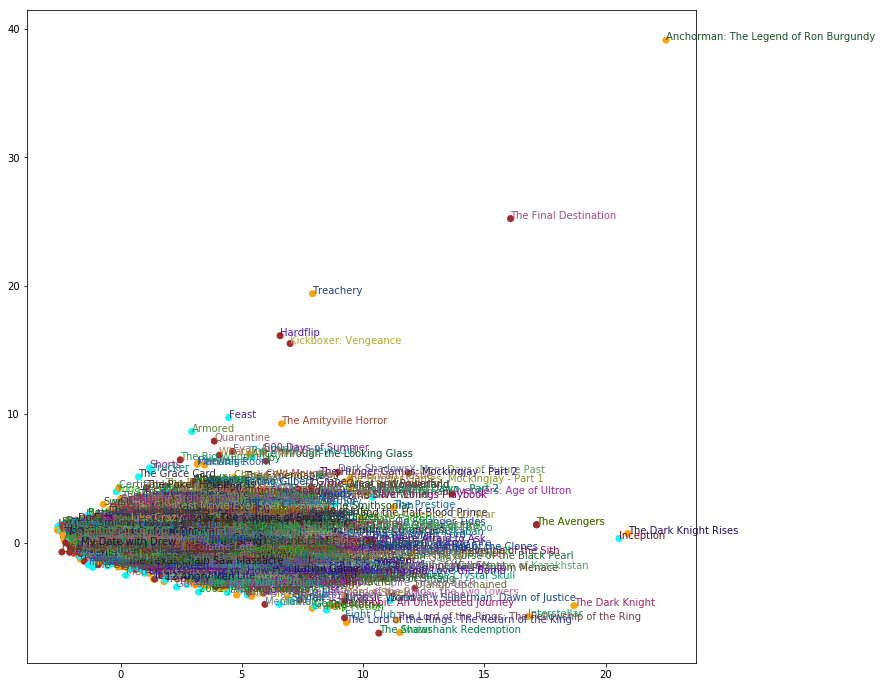

In [64]:
plt.figure(figsize=(12,12))
plt.scatter(df['pca_one'], df['pca_two'], color=['orange', 'cyan', 'brown'], cmap='viridis')

for m, p1, p2 in zip(df['movie_title'], df['pca_one'], df['pca_two']):
    plt.text(p1, p2, s=m, color=np.random.rand(3)*0.7)

In [69]:
km = KMeans(n_clusters = 5)

In [70]:
#P_fit = km.fit(df[['gross','imdb_score','num_critic_for_reviews','director_facebook_likes','actor_1_facebook_likes','movie_facebook_likes','actor_3_facebook_likes','actor_2_facebook_likes']])
P_fit = km.fit(df[['gross','imdb_score']])
P_fit.labels_
# colormap = {0:'red',1:'green',2:'blue'}
# lc =  [colormap[c] for c in colormap]
# plt.scatter(df['pca_one'],df['pca_two'],c = lc)


array([2, 2, 3, ..., 4, 4, 4], dtype=int32)

In [71]:
df['cluster'] = P_fit.labels_

In [72]:
np.unique(P_fit.labels_)

array([0, 1, 2, 3, 4], dtype=int32)

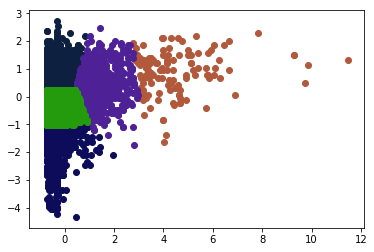

In [74]:
for i in np.unique(P_fit.labels_):
    temp = df[df['cluster'] == i]
    plt.scatter(temp['gross'], temp['imdb_score'], color=np.random.rand(3)*0.7)